# Machine Learning with scikit-learn

* What is Machine Learning?
  * Types of Machine Learning
* Train-Test split
* Use `sklearn` to build linear regression model
* One-Hot Encoding
* Pipelines
* Evaluation Metrics

We will be referencing the [scikit-learn docs](https://scikit-learn.org/stable/user_guide.html) and [pandas docs](https://pandas.pydata.org/pandas-docs/stable/index.html) where relevant, and will be analyzing data from the New York Times COVID-19 US States dataset from https://github.com/nytimes/covid-19-data

**Disclaimer: Linear regression is not the most suitable algorithm for this dataset, but we are using it to illustrate how to use scikit-learn**

## What is Machine Learning?

* Learning patterns in your data without being explicitly programmed
* A function that maps features to an output

![](https://brookewenig.com/img/DL/al_ml_dl.png)

-sandbox
## Types of Machine Learning
* Supervised Learning
  * Regression <img src="https://miro.medium.com/max/640/1*LEmBCYAttxS6uI6rEyPLMQ.png" style="height: 250px; padding: 10px"/>
  * Classification
    <img src="https://cdn3-www.dogtime.com/assets/uploads/2018/10/puppies-cover.jpg" style="height: 250px; padding: 10px"/>
    <img src="https://images.unsplash.com/photo-1529778873920-4da4926a72c2?ixlib=rb-1.2.1&w=1000&q=80" style="height: 250px; padding: 10px"/>
* Unsupervised Learning
<img src="https://www.iotforall.com/wp-content/uploads/2018/01/Screen-Shot-2018-01-17-at-8.10.14-PM.png" style="height: 250px; padding: 10px"/>
* Reinforcement Learning
<img src="https://brookewenig.com/img/ReinforcementLearning/Rl_agent.png" style="height: 250px; padding: 10px"/>

Let's focus on a supervised learning (regression) problem. Here we will use a linear regression model to predict the number of deaths resulting from COVID-19.

In [5]:
%fs ls databricks-datasets/COVID/covid-19-data/us-states.csv

path,name,size
dbfs:/databricks-datasets/COVID/covid-19-data/us-states.csv,us-states.csv,278655


In [6]:
import pandas as pd

df = pd.read_csv("/dbfs/databricks-datasets/COVID/covid-19-data/us-states.csv")
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [7]:
df.shape

Out[2]: (8539, 5)

## Relationship between Cases & Deaths

In [9]:
# To allow us to print out plots
%matplotlib inline

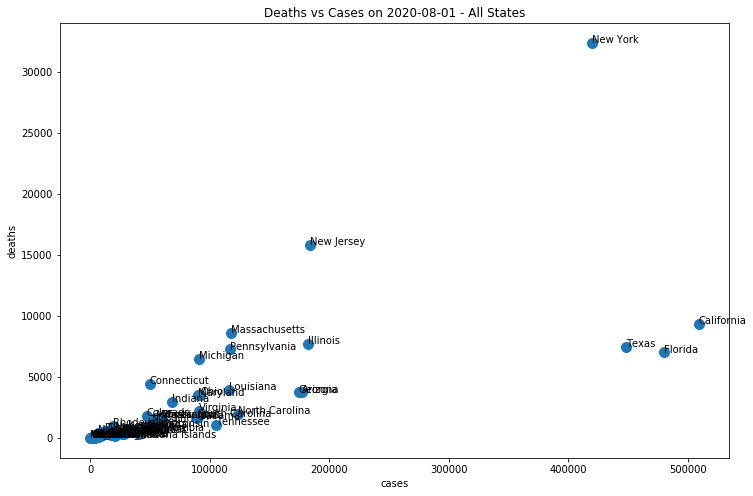

In [10]:
# Filter to 2020-08-06
df_04_14 = df[df["date"] == "2020-08-01"] #2020-04-14

ax = df_04_14.plot(x="cases", y="deaths", kind="scatter", 
                   figsize=(12,8), s=100, title="Deaths vs Cases on 2020-08-01 - All States")

df_04_14[["cases", "deaths", "state"]].apply(lambda row: ax.text(*row), axis=1);

## New York & New Jersey are Outliers & California

In [12]:
# Filter to states that are NOT New York and NOT New Jersey and NOT Florida and NOT California and NOT Texas
not_ny = df[(df["state"] != "New York") & (df["state"] != "New Jersey") & (df["state"] != "Florida") & (df["state"] != "California") & (df["state"] != "Texas")]
not_ny.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


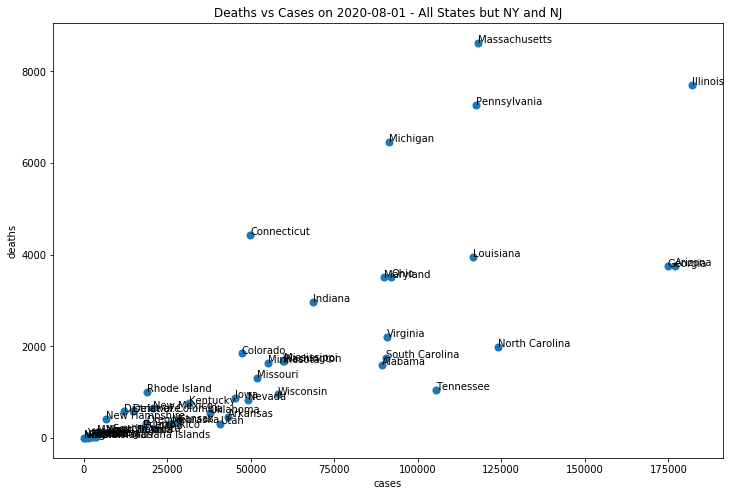

In [13]:
# Filter to 2020-08-01
not_ny_04_14 = not_ny[not_ny["date"] == "2020-08-01"] # 2020-04-14

ax = not_ny_04_14.plot(x="cases", y="deaths", kind="scatter", 
                   figsize=(12,8), s=50, title="Deaths vs Cases on 2020-08-01 - All States but NY and NJ")

not_ny_04_14[["cases", "deaths", "state"]].apply(lambda row: ax.text(*row), axis=1);

## New York verus California COVID-19 deaths comparison

In [15]:
df_ny_cali = df[(df["state"] == "New York") | (df["state"] == "California") | (df["state"] == "Florida") | (df["state"] == "Texas")]

# Let's pivot our df_ny_cali DataFrame so that we can plot deaths over time for all states
df_ny_cali_pivot = df_ny_cali.pivot(index='date', columns='state', values='deaths').fillna(0)
df_ny_cali_pivot

state,California,Florida,New York,Texas
date,,,,
2020-01-25,0.00,0.00,0.00,0.00
2020-01-26,0.00,0.00,0.00,0.00
2020-01-27,0.00,0.00,0.00,0.00
2020-01-28,0.00,0.00,0.00,0.00
2020-01-29,0.00,0.00,0.00,0.00
...,...,...,...,...
2020-07-31,9222.00,6842.00,32372.00,7271.00
2020-08-01,9365.00,7021.00,32390.00,7477.00
2020-08-02,9399.00,7083.00,32401.00,7518.00


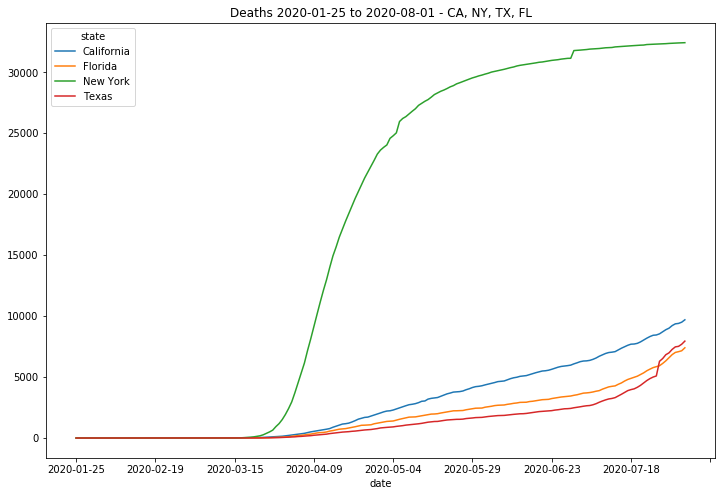

In [16]:
df_ny_cali_pivot.plot.line(title="Deaths 2020-01-25 to 2020-08-01 - CA, NY, TX, FL", figsize=(12,8))

## Train-Test Split

![](https://brookewenig.com/img/IntroML/trainTest.png)

Because this is temporal data, instead of doing a random split, we will use data from March 1 to April 7 to train our model, and test our model by predicting values for July 1 - 31.

In [19]:
train_df = df[(df["date"] >= "2020-03-01") & (df["date"] <= "2020-04-08")]
test_df = df[df["date"] > "2020-07-31"]

X_train = train_df[["cases"]]
y_train = train_df["deaths"]

X_test = test_df[["cases"]]
y_test = test_df["deaths"]

## Linear Regression

* Goal: Find the line of best fit
$$\hat{y} = w_0 + w_1x$$

$$\{y} ≈ \hat{y} + ϵ$$
* *x*: feature
* *y*: label

![](https://miro.medium.com/max/640/1*LEmBCYAttxS6uI6rEyPLMQ.png)

Here we will be fitting a [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model from scikit-learn.

In [22]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)
print(f"num_deaths = {lr.intercept_:.4f} + {lr.coef_[0]:.4f}*cases")

num_deaths = -20.5400 + 0.0384*cases

Hmmm... if we have no cases, then there should be no deaths caused by COVID-19, so let's set the intercept to be 0.

In [24]:
lr = LinearRegression(fit_intercept=False).fit(X_train, y_train)
print(f"num_deaths = {lr.coef_[0]:.4f}*cases")

num_deaths = 0.0379*cases

So this model is implying that there is a 3.79% mortality rate in our dataset. But we know that some states have higher mortality rates than others. Let's include the state as a feature!

## One-Hot Encoding
How do we handle non-numeric features, such as the state?

One idea:
* Create single numerical feature to represent non-numeric one
* Categorical features:
  * state = {'New York', 'California', 'Louisiana'}
  * 'New York' = 1, 'California' = 2, 'Louisiana' = 3
  
BUT this implies California is 2x New York!

Better idea:
* Create a ‘dummy’ feature for each category
* 'New York' => [1, 0, 0], 'California' => [0, 1, 0], 'Louisiana' => [0, 0, 1]

This technique is known as ["One Hot Encoding"](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [27]:
from sklearn.preprocessing import OneHotEncoder

X_train = train_df[["cases", "state"]]
X_test = test_df[["cases", "state"]]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(X_train).transform(X_train)

Out[36]: array([[1., 0., 0., ..., 0., 0., 0.],
 [0., 0., 0., ..., 0., 0., 0.],
 [0., 1., 0., ..., 0., 0., 0.],
 ...,
 [0., 0., 0., ..., 1., 0., 0.],
 [0., 0., 0., ..., 0., 1., 0.],
 [0., 0., 0., ..., 0., 0., 1.]])

Let's check the shape

In [29]:
enc.fit(X_train).transform(X_train).shape

Out[37]: (1809, 958)

Yikes! It one-hot encoded the cases variable too

In [31]:
enc.categories_

Out[38]: [array([ 1, 2, 3, 4, 5, 6, 7, 8,
 9, 10, 11, 12, 13, 14, 15, 16,
 17, 18, 19, 20, 21, 22, 23, 24,
 25, 26, 27, 28, 29, 30, 31, 32,
 33, 34, 35, 36, 37, 38, 39, 40,
 41, 42, 43, 44, 45, 46, 47, 48,
 49, 50, 51, 52, 53, 54, 55, 56,
 57, 58, 59, 60, 61, 62, 63, 64,
 65, 66, 67, 68, 69, 70, 71, 72,
 73, 74, 75, 76, 77, 78, 79, 80,
 81, 82, 83, 84, 85, 86, 87, 88,
 89, 90, 91, 92, 93, 94, 95, 96,
 97, 98, 99, 100, 101, 102, 103, 104,
 105, 106, 107, 108, 109, 110, 112, 113,
 114, 115, 116, 118, 119, 120, 121, 122,
 123, 124, 126, 127, 128, 129, 130, 131,
 132, 133, 134, 136, 137, 138, 139, 140,
 141, 142, 143, 144, 145, 146, 147, 150,
 151, 152, 153, 154, 155, 156, 157, 158,
 159, 161, 162, 164, 165, 166, 167, 168,
 169, 171, 172, 173, 174, 175, 176, 177,
 179, 182, 183, 184, 185, 186, 187, 189,
 190, 191, 193, 194, 195, 196, 197, 198,
 199, 200, 201, 202, 203, 204, 207, 209,
 210, 211, 212, 213, 214, 216, 217, 218,
 219, 221, 223, 224, 225, 230, 231, 232,
 234, 235, 236, 237, 239, 240, 241, 242,
 245, 247, 248, 249, 251, 252, 253, 254,
 255, 256, 257, 258, 262, 264, 265, 266,
 267, 268, 269, 272, 273, 274, 275, 278,
 279, 280, 281, 282, 283, 286, 288, 289,
 290, 291, 293, 294, 297, 298, 299, 302,
 303, 304, 307, 310, 312, 314, 315, 316,
 317, 319, 320, 321, 322, 325, 326, 327,
 328, 332, 333, 334, 336, 338, 339, 342,
 344, 346, 347, 349, 350, 351, 363, 364,
 367, 368, 369, 371, 374, 376, 377, 378,
 381, 382, 384, 385, 386, 388, 389, 390,
 392, 393, 394, 397, 398, 401, 402, 403,
 405, 408, 409, 413, 415, 418, 419, 420,
 421, 423, 424, 425, 427, 429, 432, 433,
 434, 435, 438, 439, 442, 444, 449, 450,
 452, 456, 461, 470, 475, 478, 479, 480,
 481, 482, 483, 484, 486, 488, 489, 491,
 495, 498, 499, 504, 508, 511, 512, 513,
 519, 522, 525, 526, 535, 537, 538, 540,
 542, 543, 544, 547, 548, 549, 552, 554,
 562, 564, 566, 573, 575, 576, 579, 581,
 583, 586, 588, 590, 591, 593, 603, 605,
 607, 608, 609, 610, 614, 618, 620, 621,
 623, 624, 625, 629, 639, 644, 646, 653,
 657, 661, 665, 669, 670, 673, 674, 675,
 678, 683, 686, 689, 690, 699, 702, 707,
 711, 715, 719, 720, 721, 728, 732, 735,
 737, 738, 739, 742, 743, 747, 751, 754,
 757, 759, 762, 763, 764, 769, 773, 775,
 777, 783, 784, 786, 787, 788, 789, 790,
 794, 800, 806, 827, 830, 837, 848, 851,
 853, 854, 857, 865, 867, 868, 875, 879,
 887, 889, 891, 893, 896, 899, 902, 905,
 908, 909, 912, 920, 922, 925, 927, 928,
 930, 935, 937, 946, 947, 950, 972, 981,
 986, 989, 992, 997, 998, 999, 1000, 1012,
 1020, 1026, 1033, 1042, 1044, 1047, 1048, 1049,
 1055, 1057, 1066, 1067, 1068, 1069, 1073, 1076,
 1077, 1082, 1083, 1086, 1095, 1097, 1100, 1108,
 1113, 1116, 1120, 1132, 1144, 1145, 1151, 1154,
 1159, 1166, 1169, 1170, 1172, 1177, 1180, 1181,
 1210, 1211, 1222, 1228, 1229, 1232, 1239, 1244,
 1248, 1249, 1251, 1269, 1270, 1279, 1283, 1285,
 1289, 1291, 1293, 1298, 1303, 1324, 1326, 1336,
 1350, 1351, 1358, 1363, 1375, 1385, 1388, 1393,
 1404, 1406, 1413, 1415, 1426, 1432, 1440, 1450,
 1455, 1458, 1467, 1470, 1511, 1522, 1523, 1524,
 1527, 1535, 1542, 1544, 1549, 1552, 1554, 1569,
 1580, 1591, 1600, 1618, 1632, 1638, 1641, 1655,
 1662, 1665, 1690, 1700, 1706, 1721, 1730, 1735,
 1737, 1738, 1758, 1769, 1791, 1795, 1797, 1834,
 1838, 1840, 1844, 1851, 1858, 1860, 1874, 1880,
 1914, 1915, 1916, 1917, 1933, 1971, 1985, 1993,
 2003, 2005, 2011, 2019, 2049, 2061, 2093, 2101,
 2112, 2113, 2177, 2197, 2198, 2199, 2217, 2232,
 2240, 2267, 2269, 2291, 2293, 2305, 2315, 2318,
 2331, 2367, 2381, 2387, 2402, 2408, 2417, 2440,
 2447, 2466, 2469, 2478, 2498, 2538, 2548, 2552,
 2571, 2577, 2578, 2585, 2628, 2636, 2644, 2683,
 2689, 2722, 2726, 2746, 2756, 2758, 2815, 2844,
 2868, 2870, 2877, 2903, 2990, 3029, 3032, 3037,
 3056, 3065, 3125, 3128, 3183, 3198, 3208, 3220,
 3240, 3265, 3312, 3315, 3327, 3332, 3346, 3423,
 3441, 3455, 3538, 3539, 3547, 3557, 3588, 3609,
 3644, 3655, 3675, 3728, 3739, 3753, 3770, 3824,
 3975, 4010, 4024, 4038, 4043, 4045, 4060, 4116,
 4156, 4161, 4182, 4246, 4257, 4311,

We need the [column transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) to only apply the one hot encoding to a single column.

In [33]:
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([("enc", enc, ["state"])], remainder="passthrough")
ct.fit_transform(X_train).shape

Out[39]: (1809, 56)

## Pipelines

We can chain together a series of data transformations with a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). This way we also ensure that whatever operations we apply to our training set, we also apply in the same order to our test set.

In [35]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[("ct", ct), ("lr", lr)])
pipeline_model = pipeline.fit(X_train, y_train)

y_pred = pipeline_model.predict(X_test)

## How are the different states performing?

You'll notice that by adding in additional features, our coefficient for our cases feature changed as well.

In [37]:
print(f"num_deaths = {pipeline_model.steps[1][1].coef_[-1]:.4f}*cases + state_coef")

num_deaths = 0.0408*cases + state_coef

In [38]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

categories = pipeline_model.steps[0][1].transformers[0][1].categories_[1]

pd.DataFrame(zip(categories, pipeline_model.steps[1][1].coef_[:-1]), columns=["State", "Coefficient"])

,State,Coefficient
0,Alabama,-15.26
1,Alaska,-2.10
2,Arizona,-10.31
3,Arkansas,-9.69
4,California,-79.79
5,Colorado,-24.41
6,Connecticut,-22.47
7,Delaware,-5.09
8,District of Columbia,-7.10
9,Florida,-80.60


## Evaluation Metrics

![](https://brookewenig.com/img/IntroML/RMSE.png)

Let's compute the MSE and RMSE for our dataset using the [sklearn.metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html?highlight=mean_squared_error).

In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"MSE is {mse:.1f}, RMSE is {rmse:.1f}")

MSE is 15174297.2, RMSE is 3895.4

## Visualize Predictions

In [43]:
pred = pd.concat([test_df.reset_index(drop=True), pd.DataFrame(y_pred, columns=["predicted_deaths"])], axis=1)
pred

,date,state,fips,cases,deaths,predicted_deaths
0,2020-08-01,Alabama,1,89349,1603,3631.99
1,2020-08-01,Alaska,2,3825,22,154.04
2,2020-08-01,Arizona,4,177019,3753,7215.65
3,2020-08-01,Arkansas,5,43173,458,1752.64
4,2020-08-01,California,6,509507,9365,20718.42
...,...,...,...,...,...,...
215,2020-08-04,Virginia,51,94251,2244,3829.92
216,2020-08-04,Washington,53,61829,1706,2542.03
217,2020-08-04,West Virginia,54,7051,124,282.98
218,2020-08-04,Wisconsin,55,60263,970,2449.23


Voila! You have successfully built a machine learning pipeline using scikit-learn!

To keep exploring with scikit-learn, checkout the datasets at [UCI ML Repository](https://archive.ics.uci.edu/ml/index.php) and [Kaggle](https://www.kaggle.com/)!